# Swahili News Classification Problem

[Guyo Dub Jarso ](https://www.linkedin.com/in/guyo-dub-jarso-049a1a127/).


## Overview
Kiswahili is a lingua franca spoken by 100-150 million people across East Africa. It is an official language in the DRC, Kenya, Tanzania, and Uganda; in Tanzania it is a first language for most people and the official language of instruction in all schools, while in other countries it is a common second language. News in Kiswahili is an important part of the media sphere in East Africa.

News contributes to education, technology, and economic growth of a country, and news in local languages plays an important cultural role in many Africa countries. In the modern age, African languages in news and other spheres are at risk of being lost as English becomes the dominant language in online spaces.

## Objective
The objective of this project is to develop a multi-class classification model to classify news content according to six specific categories.

## Application
This result (Model) of this project can be used by Swahili online platforms to automatically group news according to their categories and help readers find the specific news they want to read.


### Contribution
In addition, the model will contribute to a body of work ensuring that Swahili is represented in apps and other online products in future.

### Install and import neccesary libraries

In [2]:
#Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#export
import os
import time
import re
from tqdm import tqdm

#libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

##Libraries for machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


##Libraries for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

#libraries for data preprocessing
from nltk import word_tokenize
from bs4 import BeautifulSoup
from io import StringIO
import re

#libraries for saving the model
import joblib

#Functions
def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore) 

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Load the data

In [3]:
#read the data set
df = pd.read_csv('data.csv')
df.head()

,id,content,category
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa


In [69]:
#drop missing values
df = df[pd.notnull(df['content'])]

In [70]:
#get a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23268 entries, 0 to 23267
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        23268 non-null  object
 1   content   23268 non-null  object
 2   category  23268 non-null  object
dtypes: object(3)
memory usage: 727.1+ KB


In [71]:
#Check columns in the data
df.columns

Index(['id', 'content', 'category'], dtype='object')

In [72]:
# encode the category column and save as category_id
df['category_id'] = df['category'].factorize()[0]
#drop duplicates
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
#convert to a dictionary
category_to_id = dict(category_id_df.values)
#Create a dictionary of category and category_id
id_to_category = dict(category_id_df[['category_id', 'category']].values)

# Classes

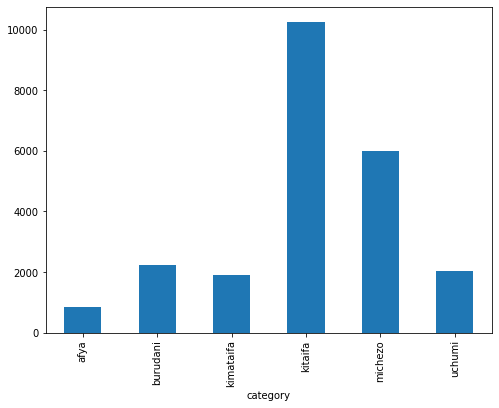

In [73]:
#Plot the classes
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').content.count().plot.bar(ylim=0)
plt.show()

It is clear from the bar chart above that the class is imbalanced

# Let See the few lines of the data

In [74]:
#Get the 5 rows of the data set
df.head()

,id,content,category,category_id
0,SW4670,"Bodi ya Utalii Tanzania (TTB) imesema, itafan...",uchumi,0
1,SW30826,"PENDO FUNDISHA-MBEYA RAIS Dk. John Magufuri, ...",kitaifa,1
2,SW29725,Mwandishi Wetu -Singida BENKI ya NMB imetoa ms...,uchumi,0
3,SW20901,"TIMU ya taifa ya Tanzania, Serengeti Boys jan...",michezo,2
4,SW12560,Na AGATHA CHARLES – DAR ES SALAAM ALIYEKUWA K...,kitaifa,1


# A few things to notice here
We have some of the noise in the data so we have to remove all that and also lets convert text into lower case.

# Preprocessing

In [75]:
df['content'] = df['content'].apply(lambda x: x.lower()) #lower casing
df['content'] = df['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # removing special chars

# Let's look at the data again

In [76]:
df.head(-5)

,id,content,category,category_id
0,SW4670,bodi ya utalii tanzania ttb imesema itafanya ...,uchumi,0
1,SW30826,pendo fundishambeya rais dk john magufuri ame...,kitaifa,1
2,SW29725,mwandishi wetu singida benki ya nmb imetoa msa...,uchumi,0
3,SW20901,timu ya taifa ya tanzania serengeti boys jana...,michezo,2
4,SW12560,na agatha charles dar es salaam aliyekuwa ka...,kitaifa,1
...,...,...,...,...
23258,SW6098,na ramadhan libenangamorogoro \nwafugaji wilay...,kitaifa,1
23259,SW24061,mwandishi wetudar es salaam zaidi ya wafanyabi...,uchumi,0
23260,SW12537,na said ameir maelezo kuwapatia wananchi dawa...,afya,5
23261,SW5272,mwili wa binadamu na viumbe wengine kama vile...,afya,5


Now the data looks better

# This looks better.

Lets pre-process the data so that we can use it to train the model

Converting news into numerical data(TFI-DF)

train test split

In [77]:
# Create tfidf features from the text
ngram_range   = (1, 1)
max_features  = None
vectorizer = TfidfVectorizer(input='content', ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)

# X, vectorizer = compute_tfidf(df['content'], stop_words, ngram_range, max_features)
X = vectorizer.fit_transform(df['content'].values)

# Encode the labels
labels = df.category.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(df.category)

# Split the dataset

In [78]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (18614, 66647)  | Test set Shape: (4654, 66647)


## Model Building

### Comparing different models in cross-validation

I am  comparing 3 models; 


- Naive Bayes (NB)

- Linear SVM

- Random Forest


Ther are so many ML models out there for multi-lass classsification but I have decided to use this three. 

However, please note that, I am  doing Multinomial Classifier because it is often the baseline classifier for a text classification. Support Vector machine because it does well in a sparse data set and will also try Random Forest Classifier because it is good in this kind of classification.



## Naive Bayes Classifier

Number of documents = 18614  |  Number of features = 66647
Start training...done!
Start testing...done!
Total time: 0.08s
accuracy: 0.7498925655350236
              precision    recall  f1-score   support

      uchumi       0.00      0.00      0.00       172
     kitaifa       0.89      0.56      0.68       446
     michezo       1.00      0.13      0.23       381
   kimataifa       0.66      0.98      0.79      2048
    burudani       0.93      0.87      0.90      1201
        afya       1.00      0.34      0.51       406

    accuracy                           0.75      4654
   macro avg       0.75      0.48      0.52      4654
weighted avg       0.78      0.75      0.71      4654



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


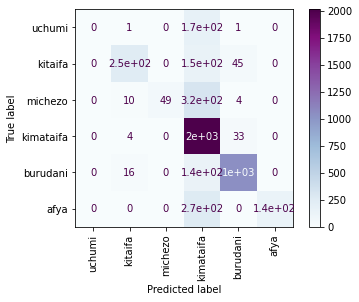

In [79]:
nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")
# plt.show()

## SVM

Number of documents = 18614  |  Number of features = 66647
Start training...done!
Start testing...done!
Total time: 0.92s
accuracy: 0.8614095401804899
              precision    recall  f1-score   support

      uchumi       0.45      0.63      0.53       172
     kitaifa       0.81      0.93      0.87       446
     michezo       0.86      0.86      0.86       381
   kimataifa       0.90      0.85      0.87      2048
    burudani       0.95      0.93      0.94      1201
        afya       0.76      0.76      0.76       406

    accuracy                           0.86      4654
   macro avg       0.79      0.83      0.80      4654
weighted avg       0.87      0.86      0.86      4654



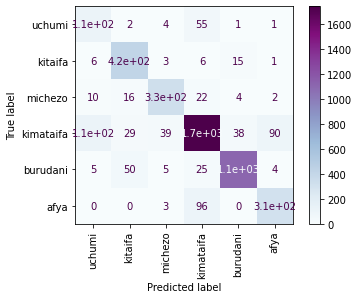

In [80]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

## Random Forest

Number of documents = 18614  |  Number of features = 66647
Start training...done!
Start testing...done!
Total time: 21.99s
accuracy: 0.807477438762355
              precision    recall  f1-score   support

      uchumi       0.21      0.03      0.06       172
     kitaifa       0.86      0.81      0.83       446
     michezo       0.91      0.46      0.62       381
   kimataifa       0.73      0.96      0.83      2048
    burudani       0.95      0.90      0.93      1201
        afya       0.99      0.39      0.56       406

    accuracy                           0.81      4654
   macro avg       0.77      0.59      0.64      4654
weighted avg       0.82      0.81      0.78      4654



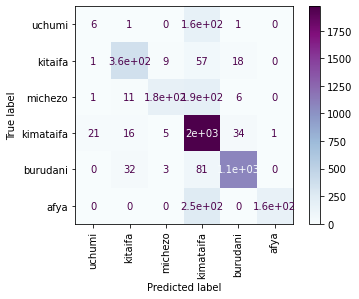

In [81]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

## Cross Validation of the model

To cope up with imbalanced datasets,  cross validation will be performed.

In [85]:
#List of all the models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]
#Choose the number of cross validations
CV = 5
#dataframe
cv_df = pd.DataFrame(index=range(CV * len(models)))
#iterate over the models, fit the models and store their accuracies in a list entries
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

#convert the list to datframe
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

### Plot model accuracies

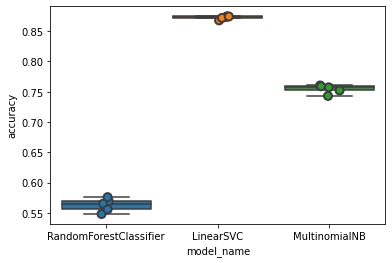

In [86]:
#plot the model accuracies
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
#group the mean accuracy of the model by the names of the model
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.870380
MultinomialNB             0.839694
RandomForestClassifier    0.659360
Name: accuracy, dtype: float64

The cross validation results show that the mean accuracy of random forest and SVM is 87%, thus still the front runner by 85% accuracy and navie Bayes ranking at position 2 with 83% accuracy

We can see also from the confusion matrix and classification report that SVM  Classifier is doing well in classifying this data

In [93]:
svm

LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=False)

In [ ]:
y_pred = svm.predict( X_test)
y_pred

# Let us look again at the confusion matrix for SVM

## Classification report

In [ ]:
#Classification report of LinearSVC
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['category'].unique()))

              precision    recall  f1-score   support

      uchumi       0.80      0.66      0.72       689
     kitaifa       0.85      0.90      0.88      3404
     michezo       0.95      0.94      0.94      1965
   kimataifa       0.84      0.85      0.85       600
    burudani       0.85      0.89      0.87       721
        afya       0.56      0.30      0.39       300

    accuracy                           0.86      7679
   macro avg       0.81      0.76      0.77      7679
weighted avg       0.86      0.86      0.86      7679



# Test the predictions

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'content']])
      print('')

'kitaifa' predicted as 'uchumi' : 112 examples.


,category,content
516,kitaifa,mamlaka ya mapato tanzania tra imekanusha hab...
13568,kitaifa,kiwanda cha kukausha matunda na viungo cha ka...
9314,kitaifa,florence sanawa lindi shirika la viwango tanza...
4027,kitaifa,wafanya biashara wengi mkoani tabora hawajili...
6601,kitaifa,wazee 27910 wamesajiliwa na kutambuliwa kwa a...
...,...,...
17537,kitaifa,naibu waziri wa mifugo na uvuvi abdallah uleg...
17196,kitaifa,na gustaphu haulepwani mkuu wa mkoa wa pwani ...
4389,kitaifa,ofisa afya wa jiji la dodoma james yana amewa...
19880,kitaifa,shirika la mawasiliano tanzania ttcl limesema...



'uchumi' predicted as 'kitaifa' : 228 examples.


,category,content
20148,uchumi,wafanyabiashara 14 kutoka mikoa ya arusha tab...
7487,uchumi,serikali inaendelea kupambana kuhakikisha kwa...
3089,uchumi,aidha rais mstaafu wa awamu ya tatu benjamin ...
9675,uchumi,ujumbe huo ulisomwa na balozi wa kenya nchini...
9958,uchumi,katibu mtendaji wa jumuiya ya maendeleo kusin...
...,...,...
21490,uchumi,katika siku hizo saba zilizokwisha juzi wafan...
19086,uchumi,serikali mkoani kilimanjaro imeomba kampuni y...
10201,uchumi,kauli hiyo ilitolewa na waziri wa maliasili n...
12376,uchumi,waziri mkuu kassim majaliwa amesema mkoa wa t...



'michezo' predicted as 'kitaifa' : 57 examples.


,category,content
14155,michezo,na fredy azzahdodoma serikali imetoa sababu ti...
20528,michezo,bakari kimwanga aliyekuwa thailand tanzania n...
11740,michezo,lulu aliye nje kwa dhamana atapanda kizimbani...
18527,michezo,juzi gari aina ya toyota land cruiser vx 8 ye...
9059,michezo,na winfrida ngonyanidar es salaam kaimu katibu...
17515,michezo,akizungumza na watalaamu kutoka morocco mjini...
1751,michezo,tamasha la utamaduni la afrika mashariki jama...
15245,michezo,taarifa ya katibu mkuu wa taswa amir mhando i...
8344,michezo,makonda aliyasema hayo jana wakati akizindua ...
23194,michezo,mashirikisho ya sanaa nchini yanatarajia kuto...



'kimataifa' predicted as 'kitaifa' : 39 examples.


,category,content
9162,kimataifa,kampala uganda tume ya mawasiliano uganda ucc...
21761,kimataifa,mbunge wa singida mashariki tundu lissu chadem...
19545,kimataifa,raia wa kenya glenn chibasellow ooko anashiki...
21496,kimataifa,tume ya mawasiliano nchini uganda\nimeagiza ku...
15942,kimataifa,na mwandishi wetu serikali ina kila sababu ya...
14785,kimataifa,na brighiter masaki mashindano ya kimataifa ya...
11614,kimataifa,na leah mushi gmt tanzania mwanaharakati wa ...
8035,kimataifa,anna potinus rais wa uganda yoweri museveni a...
16184,kimataifa,nairobi kenya miongoni mwa watu wanaohisiwa ku...
11413,kimataifa,london uingereza kansela anayeshughulikia kit...



'burudani' predicted as 'kitaifa' : 41 examples.


,category,content
10812,burudani,mchoraji james gayo na katuni yake maarufu ya ...
13619,burudani,festo polea zanzibar mwenyekiti wa bodi ya bu...
6114,burudani,\n\n \n\tna ramadhani masenga\n \n\tniaje wana...
21378,burudani,na mwandishi wetu waziri wa maliasili na utali...
2910,burudani,katikati ya mwezi novemba mwaka jana msichana ...
2509,burudani,arodia peter dodoma mbunge wa\ngeita vijijini ...
6665,burudani,na kulwa mzee dar es salaam siku mbili kabla ...
1295,burudani,na kulwa mzee dar es salaam mshereheshaji\nemm...
3198,burudani,na elly mhagama tudarco wasanii wa fani mbalim...
8173,burudani,na johanes respichius kamati ya uchaguzi wa vi...



'afya' predicted as 'kitaifa' : 185 examples.


,category,content
3173,afya,aveline kitomary dar es salaam maabara ya mkem...
7222,afya,nyemo malecelabukoba wanakijiji wenye hasira k...
13367,afya,mwandishi wetu dar es salaam waimba kwaya wa k...
17891,afya,mwandishi wetu dodoma ...
5727,afya,aveline kitomary dar es salaam waziri wa afya ...
...,...,...
18594,afya,elizabeth hombo dar es salaam rais dk john m...
21146,afya,mwandishi wetu dar es salaam kampuni inayoong...
16421,afya,na tunu nassor dar es salaam jamii imeombwa ku...
2071,afya,na veronica romwald dar es salaam serikali i...



'kitaifa' predicted as 'michezo' : 66 examples.


,category,content
5682,kitaifa,mkuu wa mkoa wa dar es salama ametangaza kuwa...
4890,kitaifa,anna potinus dar es salaam mfanyabiashara ma...
9308,kitaifa,na jennifer ullembodar es salaam mshambuliaji...
18608,kitaifa,muhadjiri hakizimana ndiye mchezaji bora wa m...
5147,kitaifa,kocha mkuu wa simba patrick aussems amesema b...
...,...,...
3498,kitaifa,makamu wa rais wa zamani wa shirikisho la sok...
5991,kitaifa,baada ya wiki iliyopita timu ya taifa taifa s...
9211,kitaifa,na mwandishi wetu dar es salaam waziri mkuu k...
20085,kitaifa,kocha wa timu ya azam fc mholanzi hans van pl...



'kimataifa' predicted as 'michezo' : 9 examples.


,category,content
19800,kimataifa,mabingwa wa ligi kuu nchini england chelsea wa...
11809,kimataifa,kiev ukraine mchezaji bora duniani cristiano ...
19978,kimataifa,mwanamke mmoja kutoka umoja wa falme za kiara...
9746,kimataifa,cairo misri nahodha wa timu ya taifa ya zimbab...
19481,kimataifa,na lulu ringo mzani umebalance michuano ya ko...
995,kimataifa,mtoto wa umri wa miaka mitano nchini urusi am...
7103,kimataifa,saint petersburg urusi leo kwenye uwanja wa s...
15754,kimataifa,\n\n \n\tbaada ya klabu ya arsenal kushinda ma...
5749,kimataifa,barcelona hispania hatimaye mshambuliaji hata...



'burudani' predicted as 'michezo' : 25 examples.


,category,content
2462,burudani,theresia gasper dar es salaam kocha mkuu wa y...
18616,burudani,na glory mlay mwimbaji nyota wa singeli nchini...
16202,burudani,kwa kipindi kirefu sasa mchezo wa riadha hapa...
130,burudani,paris ufaransa bingwa namba mbili kwa ubora w...
5590,burudani,glory mlay ligi daraja la kwanzafdl imezidi k...
15537,burudani,waziri wa habari utamaduni sanaa na michezo dr...
13777,burudani,na adam mkwepudar es salaam shirikisho la sok...
7514,burudani,na theresia gasper dar es salaam timu ya yanga...
11593,burudani,\n\n \n\tna martin mazugwa\n \n\tmoja kati ya ...
1523,burudani,na mwali ibrahim dar es salaam bendi ya muziki...



'kitaifa' predicted as 'kimataifa' : 58 examples.


,category,content
1624,kitaifa,jeshi la kenya limebainisha kuwa limewaua mag...
6109,kitaifa,waziri wa mambo ya ndani wa nchini afrika kus...
882,kitaifa,bethsheba wambura rais wa kenya uhuru kenyatt...
6256,kitaifa,nairobi kenya unaweza kusema rais uhuru kenya...
10689,kitaifa,\n\t \n \nna patricia kimelemeta dar es salaam...
12147,kitaifa,mwili wa rais wa zamani wa zimbabwe robert mu...
14031,kitaifa,idadi ya watu waliokufa kwa athari za kimbung...
20658,kitaifa,na veronica romwaldaliyekuwa kenya watu mili...
6807,kitaifa,rais wa kenya uhuru kenyatta amesema magaidi ...
15544,kitaifa,utafiti uliofanywa kwa nchi nne za afrika ume...



'michezo' predicted as 'kimataifa' : 10 examples.


,category,content
12555,michezo,akizungumza na waandishi wa habari kwa nyakat...
12988,michezo,\nmkurugenzi mtendaji wa ligi kuu ya uingereza...
20231,michezo,[ serikali ya kenya imefuta kwa muda vibali v...
7583,michezo,mwanamuziki maarufu wa congo dr koffi olomide...
13194,michezo,lionel messi picha hisani messi analalia godo...
20258,michezo,[floyd mayweather amemwambia manny pacquiao ku...
2455,michezo,rais wa zamani wa real madrid ya hispania lor...
20912,michezo,rome italia mkuu wa zamani wa kampuni ya kute...
654,michezo,paris ufaransa kiungo wa klabu ya marseille ya...
2468,michezo,new york marekani staa wa muziki nchini mareka...



'burudani' predicted as 'kimataifa' : 9 examples.


,category,content
15668,burudani,nairobi kenya nyota wa muziki nchini kenya ja...
17440,burudani,new york marekani daktari bingwa wa upasuaji ...
11889,burudani,kwa mujibu wa e news staa wa\nmitindo kutoka f...
17579,burudani,na john wisse 0655 618 385 ndugu na rafiki y...
9406,burudani,rosa ree goddess of rap kwa mara ya kwanza ame...
22901,burudani,los angeles marekani kwa mujibu wa mtandao wa ...
10061,burudani,washington dc wiki iliyopita\nrapa anayetamba ...
15885,burudani,new york marekani staa wa muziki wa rnb nchin...
21909,burudani,new york marekani hatimaye msanii wa muziki w...



'afya' predicted as 'kimataifa' : 20 examples.


,category,content
16314,afya,mwigizaji mashuhuri wa marekani\nangelina joli...
21057,afya,ferdnanda mbamila dar es salaam kituo cha msaa...
12192,afya,wuhan china tume ya afya ya china imesema maam...
7031,afya,joseph hiza na mashirika iwapo unajisikia kuc...
5323,afya,na eliya mboneaarusha taasisi ya utafiti wa w...
12209,afya,london uingereza mwanaume mmoja kutoka london ...
639,afya,surua ni moja ya magonjwa ya kuambukiza yanayo...
5295,afya,hassan daudi na mitandao licha ya matumizi ya ...
10956,afya,joseph hiza nchi ya norway inajivunia kuwa na ...
11759,afya,wanamazingira kutoka miji midogo ya pwani nch...



'kitaifa' predicted as 'burudani' : 30 examples.


,category,content
9867,kitaifa,mwaka 2019 ulikuwa mgumu kwa wasanii wa bongo...
19753,kitaifa,msanii ommy dimpoz amewazodoa waliomzushia ki...
15598,kitaifa,jeremiah ernest dar es salaam taratibu za mazi...
4057,kitaifa,na brighiter masaki msanii wa filamu nchini ro...
16611,kitaifa,na beatrice kaiza msanii\nwa filamu nchini sha...
13506,kitaifa,na christopher msekenadar es salaam mwanamiti...
21256,kitaifa,msanii maarufu wa filamu elizabeth michael ma...
1984,kitaifa,wasanii wa muziki wa bongo fleva vanessa mdee...
11752,kitaifa,kuelekea siku ya ukimwi duniani msanii maaruf...
13580,kitaifa,\n\n \n\tna christopher msekena\n \n\ttasnia y...



'michezo' predicted as 'burudani' : 48 examples.


,category,content
21233,michezo,muigizaji wa bongo movie wema sepetu amesema ...
1237,michezo,unweza kusema hivi sasa wapenzi wa soka wanata...
5494,michezo,\nvilabu vinavyoshiriki ligi kuu nchii uingere...
13549,michezo,alisema shindano hilo limefanyika kwa miezi m...
7947,michezo,hayo yalisemwa na ofisa mtendaji mkuu wa kamp...
15951,michezo,msanii huyo ameshinda tuzo ya mtv mama kwa mw...
17299,michezo,msanii salum mohamed sam wa ukweli amefariki ...
1070,michezo,miss tanzania 2019 sylivia sebastian ametinga...
13676,michezo,muigizaji wa bongo movie aunty ezekiel amesem...
2393,michezo,london england mwanariadha nchini england mo f...



'kimataifa' predicted as 'burudani' : 32 examples.


,category,content
9093,kimataifa,new york marekani staa wa muziki na filamu nch...
4025,kimataifa,hassan daudi bila shaka umewahi kukutana na sw...
22034,kimataifa,badi mchomolo na mitandao mtanzania linakulet...
3818,kimataifa,na christopher msekena hakuna msanii duniani a...
15410,kimataifa,new york marekani staa wa filamu nchini marek...
791,kimataifa,new york marekani staa wa muziki wa\nrnb nchi...
7433,kimataifa,new york marekani nyota wa muziki wa hip hop ...
6648,kimataifa,new york marekani rapa\noffset na mke wake ca...
7506,kimataifa,cape\ntown afrika kusini mashabiki wa muziki n...
8143,kimataifa,new york marekani mtoto wa staa wa muziki nchi...



'kitaifa' predicted as 'afya' : 60 examples.


,category,content
7451,kitaifa,na veronica romwald dar es salaam taasisi ya ...
17512,kitaifa,mwandishi wetu dar es salaam kampuni za kimata...
10233,kitaifa,aveline kitomary serikali kupitia wizara ya ...
22428,kitaifa,wanawake wanaongoza kwa kuwa na tatizo la une...
20242,kitaifa,tunu nassordar es salaam shirika linalojishugh...
19005,kitaifa,florence sanawa mtwara mkuu wa wilaya ya\nmtwa...
3471,kitaifa,jumla ya watoto 2345 wenye umri chini ya miak...
10234,kitaifa,nora damian na andrew msechu dar es salaam rai...
10855,kitaifa,raymond minja iringa kampuni ya fm chini ya m...
15182,kitaifa,na aveline kitomarydar es salaam mganga mkuu w...



'kimataifa' predicted as 'afya' : 6 examples.


,category,content
20758,kimataifa,na mwandishi wetu wanawake walio njia panda a...
14278,kimataifa,\n\n \n\twatafiti kutoka chuo kikuu cha queens...
20991,kimataifa,mkurugenzi mtendaji wa shirika la chakula dun...
20380,kimataifa,\n mwandishi wetu new york tanzania imetakiwa ...
12831,kimataifa,na eliya mboneaarusha majeruhi watatu wa ajal...
14143,kimataifa,frolida marekani papa aina ya great white in...


In [ ]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Show 10 Working examples

In [ ]:
#Store 10 news items in a list
texts = ["Habari ya kutatanisha kinasema ya kwamba kuna mtu ameaga dunia.",
         "Manchester United walishinda mchezo huo jana na kutinga nusu fainali.",
         "Timu ya Harambe Star yacheza na timu ya Tanzania",
         "Mwanafunzi aanguka kwenye darasa na akufa.",
         "Rais wa Marekani atembelea nchi ya Kenya na Tanzania",
         "Uchanguzi yafanyika nchi Uganda",
         "Trump hupoteza uchaguzi wake kwa Joe Biden.",
         'Rais wa Tanzania Pombe Magufuli afariki dunia.'
         ]
#transform the test data
text_features = tfidf.transform(texts)
#Predict the transformed test data
predictions = model.predict(text_features)
#iterate over the test data and their predictions and print them with their predicted class
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Habari ya kutatanisha kinasema ya kwamba kuna mtu ameaga dunia."
  - Predicted as: 'uchumi'

"Manchester United walishinda mchezo huo jana na kutinga nusu fainali."
  - Predicted as: 'michezo'

"Timu ya Harambe Star yacheza na timu ya Tanzania"
  - Predicted as: 'michezo'

"Mwanafunzi aanguka kwenye darasa na akufa."
  - Predicted as: 'kitaifa'

"Rais wa Marekani atembelea nchi ya Kenya na Tanzania"
  - Predicted as: 'kimataifa'

"Uchanguzi yafanyika nchi Uganda"
  - Predicted as: 'kitaifa'

"Trump hupoteza uchaguzi wake kwa Joe Biden."
  - Predicted as: 'kimataifa'

"Rais wa Tanzania Pombe Magufuli afariki dunia."
  - Predicted as: 'kitaifa'



# Save the best model

In [ ]:
model =svm

In [ ]:
#dumb the LinearSVC model in a pickle file
joblib.dump(model, 'LSV_Swahili_model.pkl')

['LSV_Swahili_model.pkl']

In [ ]:
#read  the model
LSV_Swahili_model = open('LSV_Swahili_model.pkl','rb')

In [ ]:
#load the model
model = joblib.load(LSV_Swahili_model)

In [ ]:
#Check model parameters
model

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

From the confusion matrix, SVM  seem to be a better classifier. We shall use it to classify our news articles. This model will be deployed in Python Flask framework, dockerize and deployed on google cloud platform with Kuberenetes to gurantee scalability.

### Note

In this we have removed stopwords from the corpus, this is because there is no complete Swahili stopwords currently available, stopwords have not been removed.


Removing the stopwords may potentially improve the accuracy of these models.